In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [6]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

In [7]:
# Trained the model in colab
#rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
#rf_model.fit(vectors, prices)

In [8]:
# Save the model to a file

#joblib.dump(rf_model, 'random_forest_model.pkl')

In [9]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

C:\Users\ASUS\anaconda3\envs\llms\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ASUS\anaconda3\envs\llms\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [11]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

C:\Users\ASUS\anaconda3\envs\llms\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ASUS\anaconda3\envs\llms\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [15]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $289.99 Truth: $374.41 Error: $84.42 SLE: 0.06 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $196.65 Truth: $225.11 Error: $28.46 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $213.42 Truth: $61.68 Error: $151.74 SLE: 1.51 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $364.84 Truth: $599.99 Error: $235.15 SLE: 0.25 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $195.52 Truth: $16.99 Error: $178.53 SLE: 5.72 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $69.63 Truth: $31.99 Error: $37.64 SLE: 0.58 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $275.91 Truth: $101.79 Error: $174.12 SLE: 0.98 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $222.00 Truth: $289.00 Error: $67.00 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $275.46 Truth: $635.86 Error: $360.40 SLE: 0.70 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $182.72 Truth: $65.99 Error: $116.73 SLE

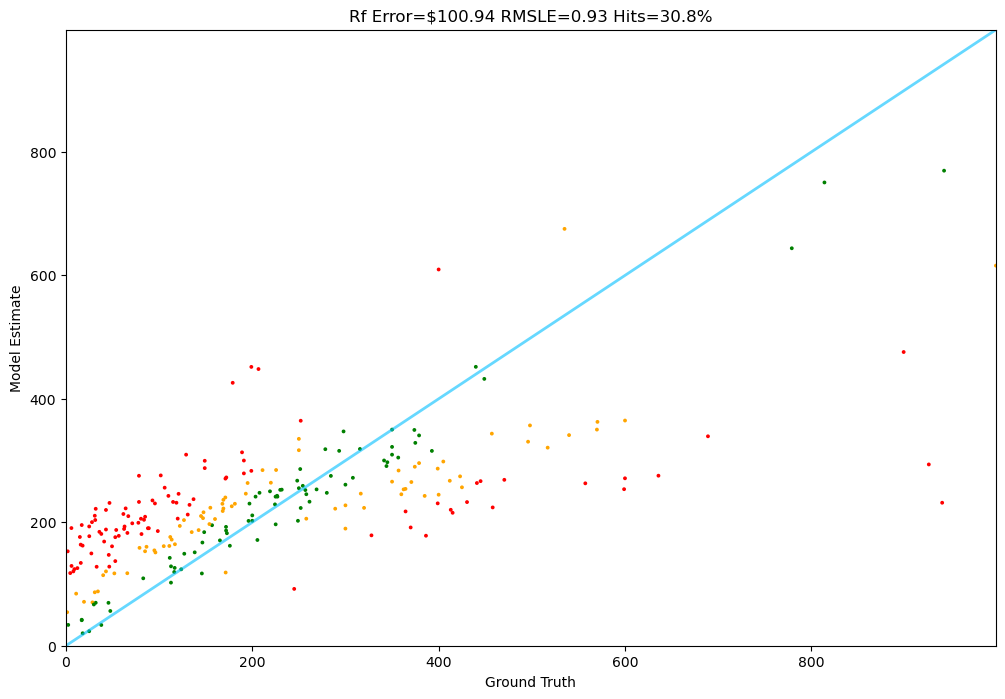

In [19]:
Tester.test(rf, test)

In [20]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [21]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

150.0
194.95
285.3588000000002


In [22]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [12:55<00:00,  3.10s/it]


In [23]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [24]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.63
Frontier: 1.08
RandomForest: 0.70
Min: -0.47
Max: -0.83
Intercept=34.54


In [25]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [26]:
# Lets make our agent

In [43]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

C:\Users\ASUS\anaconda3\envs\llms\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ASUS\anaconda3\envs\llms\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [44]:
ensemble.price(product)

231.89434677382397

In [45]:
def ensemble_pricer(item):
    return max(0,ensemble.price(description(item)))

1: Guess: $351.45 Truth: $374.41 Error: $22.96 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $225.27 Truth: $225.11 Error: $0.16 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $71.74 Truth: $61.68 Error: $10.06 SLE: 0.02 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $513.36 Truth: $599.99 Error: $86.63 SLE: 0.02 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $36.28 Truth: $16.99 Error: $19.29 SLE: 0.53 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $37.84 Truth: $31.99 Error: $5.85 SLE: 0.03 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $115.41 Truth: $101.79 Error: $13.62 SLE: 0.02 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $330.69 Truth: $289.00 Error: $41.69 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $404.53 Truth: $635.86 Error: $231.33 SLE: 0.20 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $83.02 Truth: $65.99 Error: $17.03 SLE: 0.05 Ite

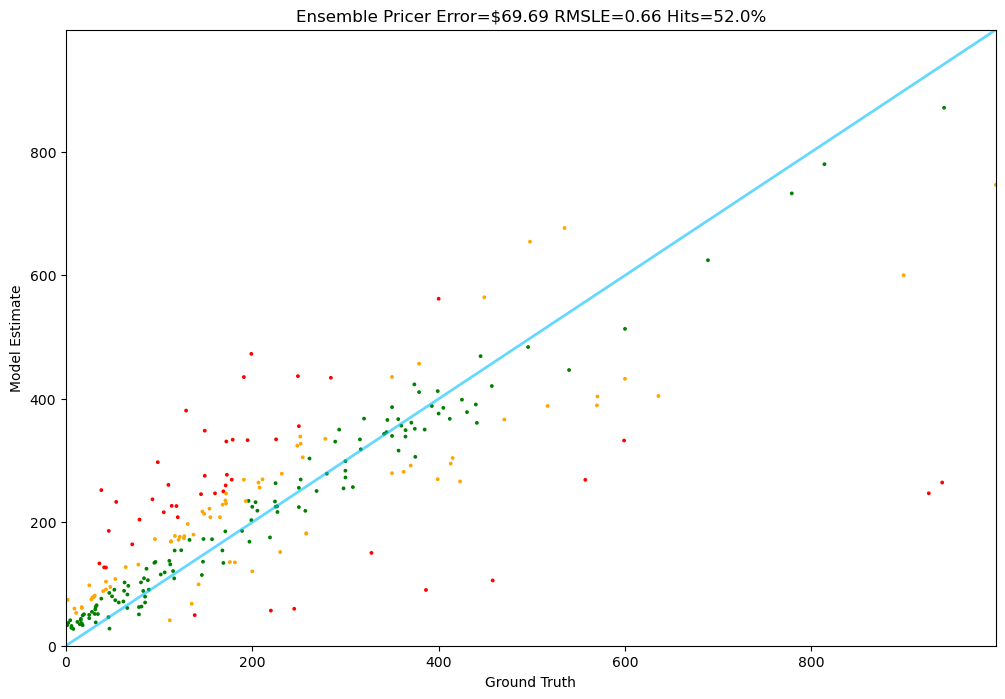

In [46]:
Tester.test(ensemble_pricer, test)